# Intelligent Data Analysis and Machine Learning I
## Exam: Creditworthiness (Project 4)

**Lamia Islam**  
lamia.islam@uni-potsdam.de  
Matrikel Nr. **822947**

# Problem Setting
This is a supervised binary classification problem. We have labeled training data where the creditworthiness outcome is known.

**Input Space**
- Feature vector: $\mathbf{x} \in \mathbb{R}^d$ where $d = 20$ features
- Features include: checking account status, duration, credit history, purpose, credit amount, savings, employment, installment rate, personal status, debtors, residence time, property, age, installment plans, housing, existing credits, job, dependents, telephone, foreign worker status (mixed categorical and numerical features)

**Output Space**
- Target variable: $y \in \{1, 2\}$ where:
  - $y = 1$: creditworthy
  - $y = 2$: not creditworthy

**Dataset Overview**
- Dataset: $\mathcal{D} = \{(\mathbf{x}_i, y_i)\}_{i=1}^{1000}$ where $n = 1000$ samples
- Missing values: Present in features "Purpose", "Present employment since", "Job", and "Foreign worker" (denoted as "?" in the data)

**Cost Matrix**
$$C = \begin{pmatrix}
0 & 1 \\
5 & 0
\end{pmatrix}$$
Where:
- $C(1,2) = 1$: Cost of predicting "not creditworthy" when actual is "creditworthy"
- $C(2,1) = 5$: Cost of predicting "creditworthy" when actual is "not creditworthy" (5× more expensive)
- $C(i,i) = 0$: No cost for correct predictions

**Objective**

Find $f: \mathcal{X} \rightarrow \{1, 2\}$ that minimizes the expected cost:

$$f^* = \arg\min_{f} \mathbb{E}_{(\mathbf{x},y) \sim P(\mathbf{X},Y)}[C(y, f(\mathbf{x}))]$$




## Importing Necessary Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
# Scikit-learn libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay,
                             precision_recall_curve, average_precision_score)

In [3]:
# Neural Network libraries
import tensorflow as tf
import keras

In [4]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

## Data Loading

In [5]:
feature_names = [
    'checking_account',   # Status of existing checking account
    'duration',           # Duration in months
    'credit_history',     # Credit history
    'purpose',            # Purpose of credit
    'credit_amount',      # Credit amount
    'savings_account',    # Savings account/bonds
    'employment',         # Present employment since
    'installment_rate',   # Installment rate in percentage of disposable income
    'personal_status',    # Personal status and sex
    'other_debtors',      # Other debtors/guarantors
    'residence_since',    # Present residence since
    'property',           # Property
    'age',                # Age in years
    'other_installments', # Other installment plans
    'housing',            # Housing
    'existing_credits',   # Number of existing credits at this bank
    'job',                # Job
    'dependents',         # Number of people liable to provide maintenance for
    'telephone',          # Telephone
    'foreign_worker',     # Foreign worker
    'target'              # Target variable (1=good, 2=bad)
]

data = pd.read_csv('kredit.dat', sep='\t', header=None, names=feature_names)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   checking_account    1000 non-null   object
 1   duration            1000 non-null   int64 
 2   credit_history      1000 non-null   object
 3   purpose             1000 non-null   object
 4   credit_amount       1000 non-null   int64 
 5   savings_account     1000 non-null   object
 6   employment          1000 non-null   object
 7   installment_rate    1000 non-null   int64 
 8   personal_status     1000 non-null   object
 9   other_debtors       1000 non-null   object
 10  residence_since     1000 non-null   int64 
 11  property            1000 non-null   object
 12  age                 1000 non-null   int64 
 13  other_installments  1000 non-null   object
 14  housing             1000 non-null   object
 15  existing_credits    1000 non-null   int64 
 16  job                 1000 

,checking_account,duration,credit_history,purpose,credit_amount,savings_account,employment,installment_rate,personal_status,other_debtors,...,property,age,other_installments,housing,existing_credits,job,dependents,telephone,foreign_worker,target
0,A14,36,A32,?,2299,A63,?,4,A93,A101,...,A123,39,A143,A152,1,A173,1,A191,?,1
1,A12,18,A32,A46,1239,A65,A73,4,A93,A101,...,A124,61,A143,A153,1,?,1,A191,A201,1
2,A13,24,A32,A40,947,A61,A74,4,A93,A101,...,A124,38,A141,A153,1,?,2,A191,?,2
3,A14,15,A33,A43,1478,A61,A73,4,A94,A101,...,A121,33,A141,A152,2,A173,1,A191,A201,1
4,A14,24,A32,A40,1525,A64,A74,4,A92,A101,...,A123,34,A143,A152,1,A173,2,A192,A201,1


## Missing Value Analysis

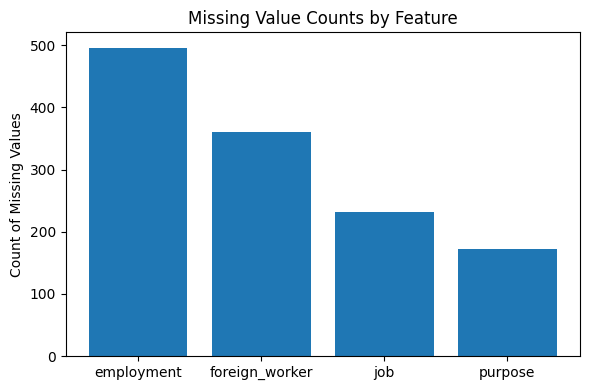

In [6]:
# Identify missing values (marked as '?')
missing_df = pd.DataFrame({
    'Feature': data.columns,
    'Missing_Count': [sum(data[col] == '?') for col in data.columns],
    'Data_Type': data.dtypes
})

missing_df = missing_df.sort_values('Missing_Count', ascending=False)

# Visualize missing values
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 4))

missing_features = missing_df[missing_df['Missing_Count'] > 0]
ax1.bar(missing_features['Feature'], missing_features['Missing_Count'])
ax1.set_title('Missing Value Counts by Feature')
ax1.set_ylabel('Count of Missing Values')
ax1.tick_params(axis='x')

plt.tight_layout()
plt.show()

## Target Variable Analysis

Target Variable Distribution:
Creditworthy (1): 700
Not Creditworthy (2): 300


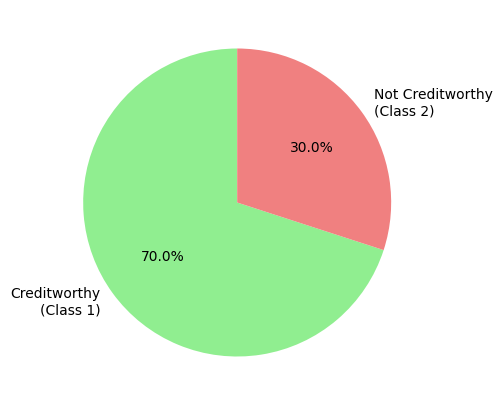

In [7]:
target_counts = data['target'].value_counts()

print("Target Variable Distribution:")
print(f"Creditworthy (1): {target_counts[1]}")
print(f"Not Creditworthy (2): {target_counts[2]}")

# Visualize target distribution
plt.figure(figsize=(5, 5))
labels = ['Creditworthy\n(Class 1)', 'Not Creditworthy\n(Class 2)']
plt.pie(target_counts.values, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral'])
plt.show()

## Feature Distribution Analysis

In [8]:
# Identify numerical and categorical features
numerical_features = [col for col in data.columns if data[col].dtype == 'int64' and col != 'target']
categorical_features = [col for col in data.columns if data[col].dtype == 'object']

print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

Numerical features (7): ['duration', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'existing_credits', 'dependents']
Categorical features (13): ['checking_account', 'credit_history', 'purpose', 'savings_account', 'employment', 'personal_status', 'other_debtors', 'property', 'other_installments', 'housing', 'job', 'telephone', 'foreign_worker']


### Numerical Feature Distribution

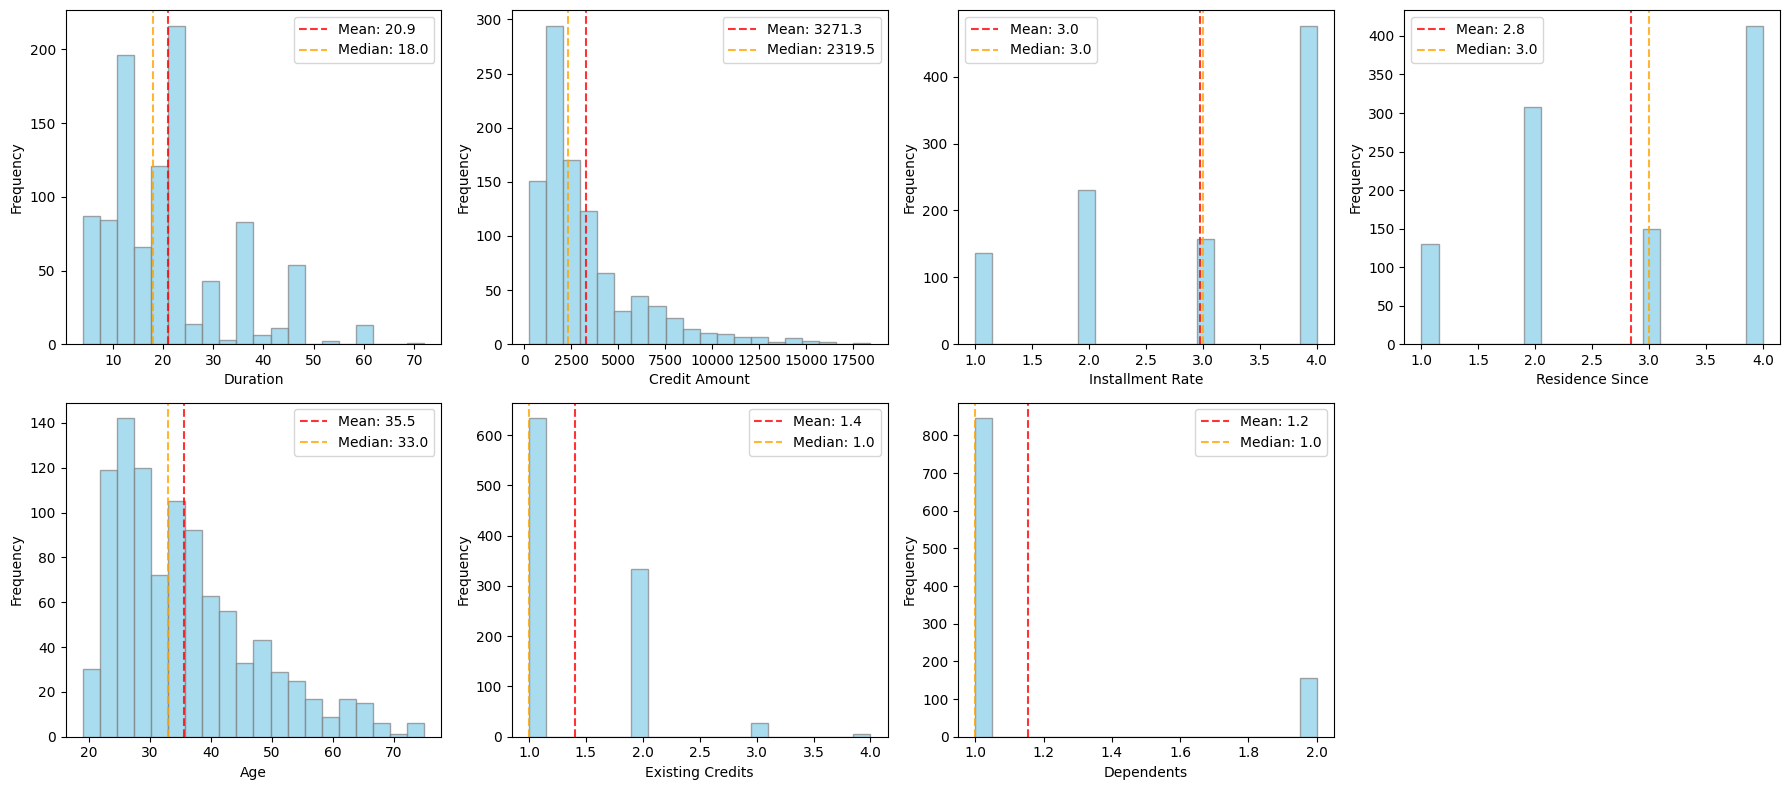

In [9]:
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    if i < len(axes):
        ax = axes[i]

        # Get numerical feature data
        feature_data = data[feature]

        # Histogram
        ax.hist(feature_data, bins=20, alpha=0.7, color='Skyblue', edgecolor='gray')
        ax.set_xlabel(feature.replace('_', ' ').title())
        ax.set_ylabel('Frequency')

        # Add statistics
        ax.axvline(feature_data.mean(), color='red', linestyle='--', alpha=0.8, label=f'Mean: {feature_data.mean():.1f}')
        ax.axvline(feature_data.median(), color='orange', linestyle='--', alpha=0.8, label=f'Median: {feature_data.median():.1f}')
        ax.legend()

# Remove empty subplots
for i in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

#### Key Insights
Duration, credit_amount, and age indicate right-skewed distributions. These continuous features require appropriate scaling during preprocessing. Additionally, variables such as installment_rate, residence_since, existing_credits, and dependents show discrete count patterns. So we can treat them as categorical variables rather than continuous numerical features.

### Categorical Feature Distribution

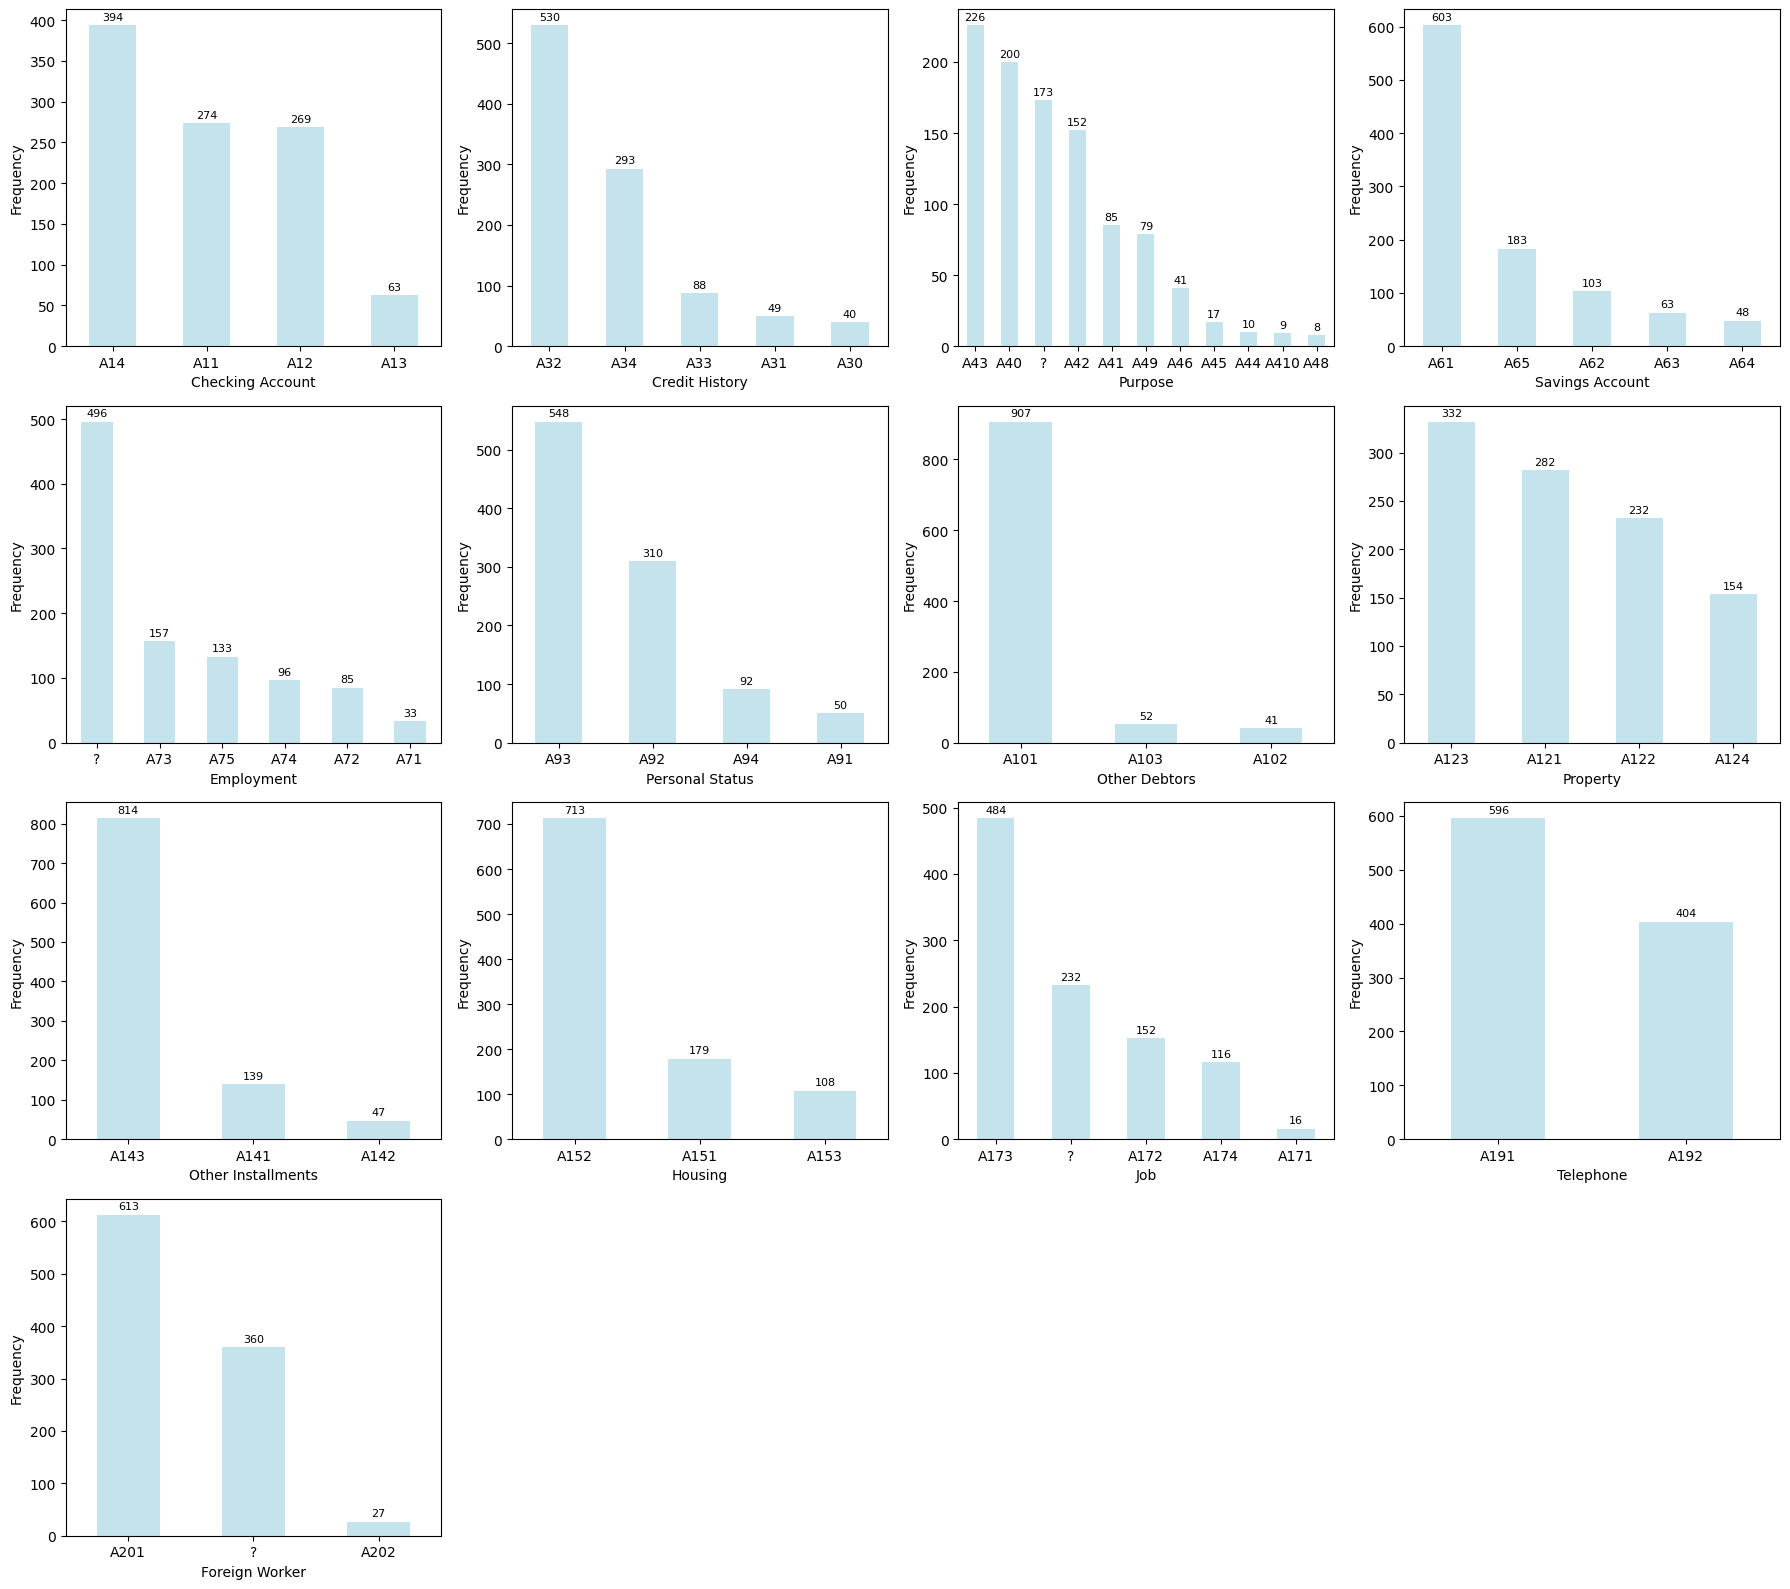

In [10]:
n_categorical = len(categorical_features)
n_cols = 4
n_rows = (n_categorical + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    if i < len(axes):
        ax = axes[i]

        # Count values including missing
        feature_counts = data[feature].fillna('Missing').value_counts()

        # Bar plot
        feature_counts.plot(kind='bar', ax=ax, color='lightblue', alpha=0.7)
        ax.set_xlabel(f'{feature.replace("_", " ").title()}')
        ax.set_ylabel('Frequency')
        ax.tick_params(axis='x', rotation=0)

        # Add value counts on bars
        for j, (category, count) in enumerate(feature_counts.items()):
            ax.text(j, count + max(feature_counts) * 0.01, str(count),
                   ha='center', va='bottom', fontsize=8)

# Remove empty subplots
for i in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### Categorical Feature vs Target

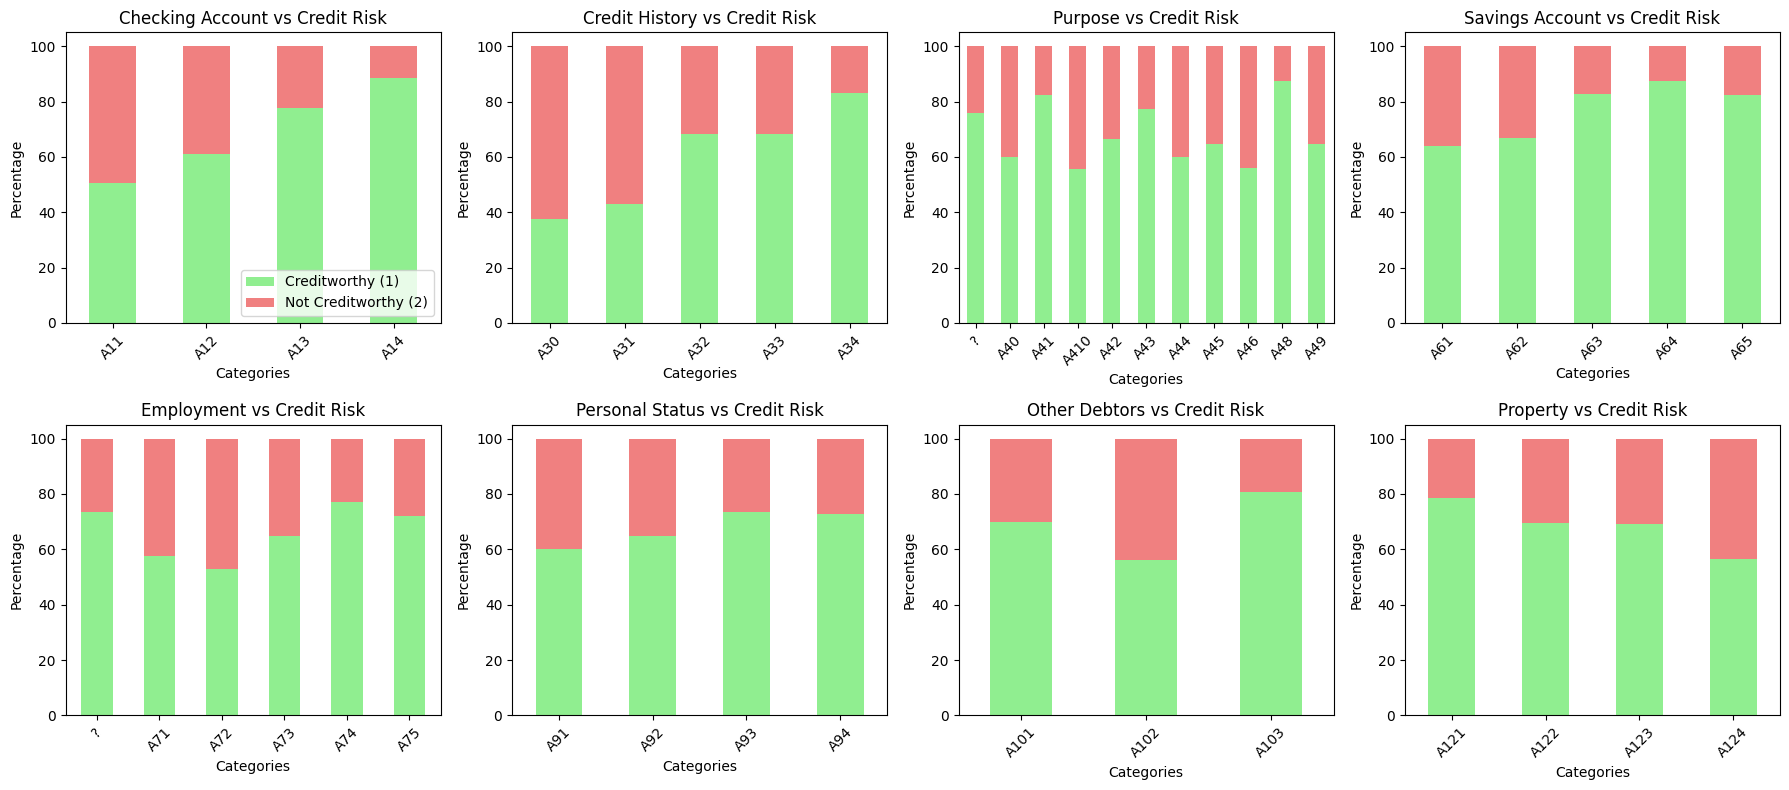

In [11]:
fig, axes = plt.subplots(2, 4, figsize=(18,8))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    if i < len(axes):
        ax = axes[i]

        # Create stacked bar chart
        cross_tab = pd.crosstab(data[feature].fillna('Missing'), data['target'], normalize='index') * 100

        cross_tab.plot(kind='bar', stacked=True, ax=ax,
                      color=['lightgreen', 'lightcoral'],
                      legend=False if i != 0 else True)

        ax.set_title(f'{feature.replace("_", " ").title()} vs Credit Risk')
        ax.set_xlabel('Categories')
        ax.set_ylabel('Percentage')
        ax.tick_params(axis='x', rotation=45)

        if i == 0:
            ax.legend(['Creditworthy (1)', 'Not Creditworthy (2)'], loc='lower right')

plt.tight_layout()
plt.show()

#### Key Insights
From the visualization, we observe that except Checking Account, other categorical features don't exhibit meaningful ordinal relationships. This insight informs our preprocessing strategy: binary features (telephone and foreign worker) can be encoded using simple 0/1 mapping, while the remaining categorical features will be transformed using one-hot encoding to maintain their non-ordinal nature to avoid any artificial ordering.

## Data Preprocessing

We will perform the following preprocessing on the data:

1. For simplicity of calculation, we will convert target values from (1,2) to (1,0), and missing values from '?' to NaN. Then we will create a new dataframe by excluding the target variable to avoid data leakage during model training

2. After that we will first handle the missing values

3. Lastly, we will normalize the continuous features and encode categorical variables

In [12]:
# replace 2 as 0
data.target.replace([1,2], [1,0], inplace=True)

# replace '?' with 'NaN'
data.replace("?", np.nan, inplace=True)

label = data['target']
df_new = data.drop(columns=['target'])

print(df_new.shape)

(1000, 20)


### Handling Missing Values
In the Aufgabe, it is explicitly mentioned to replace missing values (marked as '?') using linear regression or classification methods. Since all four features with missing values are categorical and three of them are multi-class, we will use **Logistic Regression** for imputation. While other linear classifiers could be used, they would require multiple planes (e.g., one-vs-rest) for multi-class problems, adding more complexity. So that, we will be using a straightforward method that directly addresses our multi-class categorical problem.

In [13]:
def impute_missing_values(data, missing_features_df):
  data_imputed = data.copy()
  missing_features_list = missing_features_df["Feature"].tolist()


  for feature in missing_features_list:
    complete_mask = data_imputed[feature].notna()
    incomplete_mask = data_imputed[feature].isna()


    predictor_cols = [col for col in data_imputed.columns if col != feature]
    X_train = data_imputed.loc[complete_mask, predictor_cols]
    y_train = data_imputed.loc[complete_mask, feature]
    X_predict = data_imputed.loc[incomplete_mask, predictor_cols]


    # Simple mode imputation for predictors with missing values
    for col in predictor_cols:
      if X_train[col].isnull().any():
        mode_val = X_train[col].mode().iloc[0]
        X_train[col] = X_train[col].fillna(mode_val)
        X_predict[col] = X_predict[col].fillna(mode_val)


    # One-hot encode categorical predictors
    cat_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    encoder.fit(pd.concat([X_train[cat_cols], X_predict[cat_cols]]))

    X_train_enc = encoder.transform(X_train[cat_cols])
    X_predict_enc = encoder.transform(X_predict[cat_cols])

    X_train_final = np.hstack([X_train.drop(columns=cat_cols).to_numpy(), X_train_enc])
    X_predict_final = np.hstack([X_predict.drop(columns=cat_cols).to_numpy(), X_predict_enc])

    # Train model for imputation
    model = LogisticRegression(
      multi_class="multinomial" if len(np.unique(y_train)) > 2 else "auto",
      class_weight="balanced",
      random_state=42,
      max_iter=1000
    )
    model.fit(X_train_final, y_train)
    y_pred = model.predict(X_predict_final)


    data_imputed.loc[incomplete_mask, feature] = y_pred

  return data_imputed

In [14]:
data_imputed = impute_missing_values(df_new, missing_features)

In [15]:
# Check for missing values in the imputed data
print(f'Number of Missing Values\n{data_imputed.isnull().sum()}')

Number of Missing Values
checking_account      0
duration              0
credit_history        0
purpose               0
credit_amount         0
savings_account       0
employment            0
installment_rate      0
personal_status       0
other_debtors         0
residence_since       0
property              0
age                   0
other_installments    0
housing               0
existing_credits      0
job                   0
dependents            0
telephone             0
foreign_worker        0
dtype: int64


### Feature Representation

#### Numerical Features

We will perform **Log Scaling** to address the right-skewness in the numerical continuous features.

In [16]:
def log_scale(data, numeric_cols):
    """
    Apply log scaling followed by standard scaling to numeric features.

    Parameters:
    -----------
    data : pd.DataFrame
        Input dataframe
    numeric_cols : list of str
        List of numeric feature names to scale

    Returns:
    --------
    pd.DataFrame
        Dataframe with scaled numeric features (other columns untouched)
    """
    df_scaled = data.copy()

    # Apply log scaling
    data_scaled = np.log1p(np.maximum(data[numeric_cols], 0))

    # Replace numeric columns with scaled values
    df_scaled[numeric_cols] = pd.DataFrame(data_scaled, columns=numeric_cols, index=data.index)

    return df_scaled

In [17]:
def min_max_scale(data, numeric_cols):
    """
    Apply min-max scaling to numeric features.

    Parameters:
    -----------
    data : pd.DataFrame
        Input dataframe
    numeric_cols : list of str
        List of numeric feature names to scale

    Returns:
    --------
    pd.DataFrame
        Dataframe with min-max scaled numeric features (other columns untouched)
    """
    df_scaled = data.copy()

    for col in numeric_cols:
        min_val = df_scaled[col].min()
        max_val = df_scaled[col].max()
        df_scaled[col] = (df_scaled[col] - min_val) / (max_val - min_val)

    return df_scaled

#### Categorical Features

Based on the relationship analysis with target variable, most categorical features don't indicate ordinal patterns. Therefore, our encoding strategy is:

1. **Binary encoding** for the binary features: Telephone, Foreign worker
2. **One-hot encoding** for all other categorical features

In [18]:
def binary_encoding(data, binary_mappings):
    """
    Apply binary encoding to specified categorical features.

    Parameters:
    -----------
    data : pd.DataFrame
        Input dataframe
    binary_mappings : dict
        Mapping of {column_name: {category_value: binary_value, ...}}
    Returns:
    --------
    pd.DataFrame
        Dataframe with binary encoded features and original columns dropped
    """
    data_binary = data.copy()

    for col, mapping in binary_mappings.items():
        new_col = f"{col}_binary"
        data_binary[new_col] = data_binary[col].map(mapping).astype(int)
        data_binary = data_binary.drop(columns=[col])

    return data_binary

In [19]:
def onehot_encoding(data, categorical_cols):
    """
    Apply one-hot encoding to categorical features.

    Parameters:
    -----------
    data : pd.DataFrame
        Input dataframe
    categorical_cols : list of str
        List of categorical feature names to encode

    Returns:
    --------
    pd.DataFrame
        Dataframe containing only the encoded categorical features
    """
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

    # Fit + transform categorical features
    data_encoded = encoder.fit_transform(data[categorical_cols])

    # Extract column names
    encoded_cols = encoder.get_feature_names_out(categorical_cols)

    # Return as dataframe
    df_encoded = pd.DataFrame(data_encoded, columns=encoded_cols, index=data.index)

    return df_encoded

In [29]:
# Step 1: scale numeric
skewed_cols = ["duration", "credit_amount", "age"]
df_log_scaled = log_scale(data_imputed, skewed_cols)

# Step 2: Min-max scale all numerical features (including log-scaled ones)
df_scaled = min_max_scale(df_log_scaled, numerical_features)

# Step 2: binary encode
binary_mappings = {
    "telephone": {"A191": 0, "A192": 1},
    "foreign_worker": {"A201": 1, "A202": 0}
}
df_binary = binary_encoding(df_scaled, binary_mappings)

# Step 3: one-hot encode
categorical_cols = [col for col in df_binary.columns if df_binary[col].dtype == 'object']
df_encoded = onehot_encoding(df_binary, categorical_cols)

# Final combined dataframe
df_final = pd.concat([df_binary.drop(columns=categorical_cols), df_encoded], axis=1)

df_final.head()

,duration,credit_amount,installment_rate,residence_since,age,existing_credits,dependents,telephone_binary,foreign_worker_binary,checking_account_A11,...,other_installments_A141,other_installments_A142,other_installments_A143,housing_A151,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174
0,0.746536,0.515644,1.0,1.000000,0.519211,0.000000,0.0,0,1,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.497945,0.371837,1.0,1.000000,0.847492,0.000000,0.0,0,1,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.600308,0.309334,1.0,0.666667,0.500246,0.000000,1.0,0,1,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.433846,0.412864,1.0,0.666667,0.397474,0.333333,0.0,0,1,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.600308,0.420146,1.0,0.666667,0.419188,0.000000,1.0,1,1,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Model Training


### Dataset Splitting
For consistency, we have divided the dataset into training and test set before starting training.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df_final, label, test_size = 0.25, random_state=42)

print(f'X train',X_train.shape)
print(f'X test',X_test.shape)
print(f'y train',y_train.shape)
print(f'y test',y_test.shape)

X train (750, 59)
X test (250, 59)
y train (750,)
y test (250,)


### Hyperparameter Tuning
We will use **nested cross-validation** to ensure unbiased model evaluation and prevent data leakage:
- Outer Loop (5-fold): Provides realistic performance estimates by keeping test data completely separate during hyperparameter tuning
- Inner Loop (3-fold): Optimizes hyperparameters using grid search with precision scoring, which directly relates to minimizing false positives (our most costly errors)

Rather than selecting the best parameters from a single fold, we return the most commonly chosen parameters across all folds,  because this better reflects the model's general preference for certain hyperparameters across different data subsets


In [22]:
def nested_cross_validation(clf, param_grid, X, y, outer_splits=5, inner_splits=3):
    """
    Nested cross-validation for hyperparameter tuning to get the best params.

    Parameters
    ----------
    clf : sklearn estimator
        Classifier to evaluate
    param_grid : dict
        Hyperparameter grid for inner CV search
    X : pd.DataFrame
        Feature matrix
    y : pd.Series
        Target labels
    outer_splits : int, default=5
        Number of outer CV folds
    inner_splits : int, default=5
        Number of inner CV folds

    Returns
    -------
    fold_results : list of dict
        Metrics and best params for each outer fold
    common_params : dict
        Most frequently chosen hyperparameters across folds
    """

    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=42)

    fold_results = []
    best_params_per_fold = []

    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        # Split data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Inner CV for hyperparameter tuning
        inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=42)
        grid = GridSearchCV(clf, param_grid, cv=inner_cv, scoring="precision", n_jobs=-1)
        grid.fit(X_train, y_train)

        best_params = grid.best_params_
        best_params_per_fold.append(best_params)
        best_model = grid.best_estimator_

        # Predictions on test fold
        y_pred = best_model.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        cost = fp * 5 + fn * 1

        # Store fold metrics
        metrics = {
            "fold": fold_idx + 1,
            "cost": cost,
            "best_params": best_params
        }
        fold_results.append(metrics)

        print(f"Fold {metrics['fold']}: Cost={metrics['cost']}, Params={metrics['best_params']}")

    # Find most common parameters across folds
    common_params = {}
    for param in param_grid:
        values = [bp[param] for bp in best_params_per_fold]
        common_params[param] = Counter(values).most_common(1)[0][0]

    print("\nMost common parameters across folds:", common_params)

    return fold_results, common_params

### Logistic Regression
This is our baseline model, as it sets a simple robust benchmark for comparison. For hyperparameter tuning in Logistic Regression, we will explore:

- **C**: Inverse of regularization strength [0.01, 0.1, 1.0, 10.0]  
    Helps prevent overfitting by controlling model complexity

- **penalty**: Regularization type ['l1', 'l2']  
    L1 can help with feature selection, L2 prevents large coefficients

- **solver**: Algorithm ['liblinear', 'saga']  
    Both support L1/L2 regularization and are efficient for our dataset size

- **class_weight**: Class balancing ['balanced']  
    Critical for our imbalanced dataset

In [27]:
def hyperParameterTuning_LogisticRegression(features, labels):
  params = {
      "C": [0.001, 0.01, 0.1, 1.0, 10.0],
      "penalty": ["l1", "l2"],
      "solver": ["liblinear", "saga"],
      "class_weight": ["balanced"],
      "max_iter": [100, 200, 500],
      "random_state": [42]
  }

  lr_model = LogisticRegression()
  X, y = features, labels
  fold_results, best_params = nested_cross_validation(lr_model, params, X, y)

  return fold_results, best_params

In [31]:
lr_fold_results, lr_best_params = hyperParameterTuning_LogisticRegression(X_train, y_train)

Fold 1: Cost=75, Params={'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga'}
Fold 2: Cost=76, Params={'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear'}
Fold 3: Cost=91, Params={'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear'}
Fold 4: Cost=114, Params={'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga'}
Fold 5: Cost=101, Params={'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear'}

Most common parameters across folds: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': 'balanced', 'max_iter': 100, 'random_state': 42}


In [32]:
logreg_model = LogisticRegression(**lr_best_params)

### Decision Tree
Decision trees are naturally interpretable and handle mixed data types, as well as can capture non linear patterns, making them ideal for understanding credit risk factors. For hyperparameter tuning in Decision Tree, we will explore:

- **max_depth**: Maximum tree depth [2, 5, 10]  
    Controls model complexity and prevents overfitting by limiting how deep the tree can grow

- **min_samples_split**: Minimum samples required to split a node [20, 50, 100]  
    Prevents overfitting by requiring sufficient data before creating new branches

- **min_samples_leaf**: Minimum samples required in leaf nodes [10, 20, 50]  
    Ensures leaf nodes represent meaningful populations and reduces overfitting

- **criterion**: Split quality measure ['gini', 'entropy']  
    Gini focuses on class purity, while entropy (information gain) measures information content reduction

- **class_weight**: Class balancing ["balanced"]  
    Adjusts node splitting to account for class imbalance

In [33]:
def hyperParameterTuning_DecisionTree(features, labels):
  params = {
      "max_depth": [2, 5, 10],
      "min_samples_split": [10, 20, 50, 100],
      "min_samples_leaf": [5, 10, 20, 50],
      "criterion": ["gini", "entropy"],
      "class_weight": ["balanced"],
      "random_state": [42]
  }

  dt_model = DecisionTreeClassifier()
  X, y = features, labels
  fold_results, best_params = nested_cross_validation(dt_model, params, X, y)

  return fold_results, best_params

In [34]:
dt_fold_results, dt_best_params = hyperParameterTuning_DecisionTree(X_train, y_train)

Fold 1: Cost=107, Params={'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 50, 'min_samples_split': 10, 'random_state': 42}
Fold 2: Cost=72, Params={'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 10, 'random_state': 42}
Fold 3: Cost=90, Params={'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 10, 'random_state': 42}
Fold 4: Cost=111, Params={'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 20, 'random_state': 42}
Fold 5: Cost=102, Params={'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 10, 'random_state': 42}

Most common parameters across folds: {'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 5, 'criterion': 'gini', 'class_weight': 'balanced', 'random_state': 42}


In [35]:
dt_model = DecisionTreeClassifier(**dt_best_params)

### Random Forest
As we saw Decision Tree performed not so well compared to our baseline model, we want to explore the ensemble version to potentially achieve better performance by combining multiple trees. For hyperparameter tuning in Random Forest, we will explore:

- **n_estimators**: Number of trees in the forest [50, 100, 200]  
    More trees generally improve performance but increase computational cost, and lead to overfitting

- **class_weight**: Class balancing ['balanced', 'balanced_subsample']  
    'balanced_subsample' resamples for each tree, while others apply globally across the forest

- **Other parameters**: Used same criteria as Decision Tree (max_depth, min_samples_split, min_samples_leaf, criterion) but applied across multiple diverse trees

- **Performance optimization**: Set n_jobs=-1 for parallel processing and warm_start=True for incremental learning

In [36]:
def hyperParameterTuning_rf(features, labels):
    params = {
        "n_estimators": [50, 100, 200],
        "max_depth": [2, 5, 10, 15],
        "min_samples_split": [5, 10, 15, 20],
        "min_samples_leaf": [2, 5, 10, 15],
        "class_weight": ["balanced", "balanced_subsample"],
        "criterion": ["gini", "entropy"],
        "random_state": [42],
        "n_jobs": [-1]
    }

    rf_model = RandomForestClassifier()
    X, y = features, labels
    fold_results, best_params = nested_cross_validation(rf_model, params, X, y)

    return fold_results, best_params

In [37]:
rf_fold_results, rf_best_params = hyperParameterTuning_rf(X_train, y_train)

Fold 1: Cost=77, Params={'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 15, 'min_samples_split': 5, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 42}
Fold 2: Cost=78, Params={'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 15, 'min_samples_split': 5, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
Fold 3: Cost=106, Params={'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 15, 'min_samples_split': 5, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 42}
Fold 4: Cost=106, Params={'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 15, 'min_samples_split': 5, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 42}
Fold 5: Cost=99, Params={'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}

Most commo

In [38]:
rf_model = RandomForestClassifier(**rf_best_params)

### Feedforward Neural Network

We will also try a neural network to see if it can find hidden patterns in our credit data that simpler models might miss. We will create just two hidden layers to avoid complexity that our small dataset might not support. The workflow will look like:
1. **Input**: Processed features → First hidden layer (32/64 neurons + ReLU)
2. **Pattern Detection**: First layer output → Second hidden layer (16/32 neurons + ReLU) 
3. **Decision**: Second layer output → Output neuron (sigmoid) → Probability
4. **Classification**: If probability > threshold, predict creditworthy

Our neural network needs to work with the same evaluation tools as the other models. So we will create a wrapper that lets us use the same cross-validation, and tune hyperparameters just like with sklearn models.

With only 750 samples, neural networks are actually at a disadvantage compared to simpler models. We're testing whether the ability to capture complex patterns outweighs this limitation in our credit risk problem.

In [39]:
def create_binary_nn_model(input_dim, hidden_units=64, dropout_rate=0.3, learning_rate=0.001):
    """
    Create a binary classification neural network model.
    
    Parameters:
    - input_dim: Number of input features
    - hidden_units: Number of neurons in first hidden layer
    - dropout_rate: Dropout rate for regularization
    - learning_rate: Learning rate for optimizer
    """
    model = keras.Sequential()
    
    # First hidden layer
    model.add(keras.layers.Dense(hidden_units, input_dim=input_dim))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dropout(dropout_rate, seed=42))
    
    # Second hidden layer
    model.add(keras.layers.Dense(hidden_units // 2))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dropout(dropout_rate, seed=42))
    
    # Output layer for binary classification
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    # Compile model 
    model.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=[keras.metrics.Precision()]
    )

    return model


class NNWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_units=64, dropout_rate=0.3, learning_rate=0.001, 
                 epochs=100, batch_size=32, threshold=0.5, patience=10):
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.threshold = threshold
        self.patience = patience

    def fit(self, X, y):
        """
        Fit the neural network model.
        """
        tf.random.set_seed(42)
        np.random.seed(42)
        
        self.classes_ = np.unique(y)
        
        #if not hasattr(self, 'model') or self.model is None:
        self.model = create_binary_nn_model(
            X.shape[1], self.hidden_units, self.dropout_rate, self.learning_rate
        )
        
        # Adjust class weights for class imbalance
        class_weights = compute_class_weight('balanced', classes=self.classes_, y=y)
        class_weight = {0: class_weights[0], 1: class_weights[1]}

        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=self.patience,
                restore_best_weights=True,
                verbose=0
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=self.patience//2,
                min_lr=1e-6,
                verbose=0
            )
        ]
        
        self.history = self.model.fit(
            X, y, 
            epochs=self.epochs, 
            batch_size=self.batch_size,
            class_weight=class_weight,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=0
        )
        
        return self
        
    def predict(self, X):
        """Make binary predictions using hyperparameter-tuned threshold."""
        probabilities = self.model.predict(X, batch_size=self.batch_size, verbose=0)
        return (probabilities > self.threshold).astype(int).flatten()

    def predict_proba(self, X):
        """Return prediction probabilities for both classes."""
        proba_class_1 = self.model.predict(X, batch_size=self.batch_size, verbose=0).flatten()
        proba_class_0 = 1 - proba_class_1
        return np.column_stack([proba_class_0, proba_class_1])

We will explore the following hyperparameters:

- **hidden_units**: Network capacity [32, 64]  
    Controls the number of neurons in the first hidden layer, determining how many patterns the network can learn. More neurons increase model complexity but risk overfitting with our small dataset.

- **dropout_rate**: Regularization strength [0.3, 0.4]  
    Randomly deactivates neurons during training to prevent overfitting. Higher values provide stronger regularization but may reduce learning capacity.

- **learning_rate**: Optimization speed [0.001, 0.01]  
    Controls how quickly the model updates its weights during training. Lower values ensure stable learning, while higher values speed up convergence but risk overshooting optimal solutions.

- **epochs**: Training duration [30, 50]  
    Number of complete passes through the training data. More epochs allow better learning but increase risk of overfitting.

- **batch_size**: Training efficiency [16, 32]  
    Number of samples processed before updating model weights. Smaller batches provide more frequent updates and better gradient estimation for our dataset size.

- **threshold**: Decision boundary [0.7, 0.8]  
    Probability cutoff for classifying as creditworthy. Higher thresholds reflect our conservative approach to minimize costly false positives in credit risk prediction.

In [48]:
def hyperParameterTuning_NeuralNetwork(features, labels):
    params = {
        "hidden_units": [32, 64, 128],
        "dropout_rate": [0.3, 0.5],
        "learning_rate": [0.001, 0.01, 0.1],
        "epochs": [30, 50],
        "batch_size": [16, 32]
    }
    
    nn_model = NNWrapper()
    X, y = features, labels
    fold_results, best_params = nested_cross_validation(nn_model, params, X, y)
    
    return fold_results, best_params

In [49]:
# Run hyperparameter tuning
nn_fold_results, nn_best_params = hyperParameterTuning_NeuralNetwork(X_train, y_train)

Fold 1: Cost=84, Params={'batch_size': 16, 'dropout_rate': 0.5, 'epochs': 50, 'hidden_units': 32, 'learning_rate': 0.01}
Fold 2: Cost=77, Params={'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 30, 'hidden_units': 128, 'learning_rate': 0.01}
Fold 3: Cost=94, Params={'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 30, 'hidden_units': 128, 'learning_rate': 0.01}
Fold 4: Cost=138, Params={'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 30, 'hidden_units': 32, 'learning_rate': 0.1}
Fold 5: Cost=103, Params={'batch_size': 16, 'dropout_rate': 0.5, 'epochs': 30, 'hidden_units': 128, 'learning_rate': 0.001}

Most common parameters across folds: {'hidden_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'epochs': 30, 'batch_size': 16}


In [42]:
nn_model = NNWrapper(**nn_best_params)

## Model Evaluation
After hyperparameter tuning, we evaluate all models on training and test sets to assess performance and generalization. Our primary goal is minimizing total cost where false positives (predicting creditworthy when actually not creditworthy) cost 5× more than false negatives.

In [43]:
models = {
    'Logistic Regression': logreg_model,
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'Neural Network': nn_model
}

In [44]:
def evaluate_all_models(models_dict, X_train, X_test, y_train, y_test):
    """
    Evaluate all models on both training and test sets.
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary with model names as keys and model objects as values
    X_train, X_test : pd.DataFrame
        Training and test feature sets
    y_train, y_test : pd.Series
        Training and test target sets
    """
    
    # Create 2x2 subplots for confusion matrices
    fig, axes = plt.subplots(2, 2, figsize=(15, 8))
    axes = axes.flatten()  # Flatten the 2x2 array for easier indexing
    
    for idx, (model_name, model) in enumerate(models_dict.items()):
        # Fit model on training data
        model.fit(X_train, y_train)
        
        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Calculate costs
        tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_train_pred).ravel()
        tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_test_pred).ravel()
        
        # Calculate metrics for training set
        train_cost = fp_train * 5 + fn_train * 1
        train_precision = tp_train / (tp_train + fp_train) if (tp_train + fp_train) > 0 else 0
        train_recall = tp_train / (tp_train + fn_train) if (tp_train + fn_train) > 0 else 0
        train_accuracy = (tp_train + tn_train) / len(y_train)
        
        # Calculate metrics for test set
        test_cost = fp_test * 5 + fn_test * 1
        test_precision = tp_test / (tp_test + fp_test) if (tp_test + fp_test) > 0 else 0
        test_recall = tp_test / (tp_test + fn_test) if (tp_test + fn_test) > 0 else 0
        test_accuracy = (tp_test + tn_test) / len(y_test)
        
        # Print metrics in table format
        print(f"\n{model_name.upper()}")
        print("-" * 50)
        print("        Cost    Precision   Recall   Accuracy")
        print(f"Train   {train_cost:3d}      {train_precision:.3f}      {train_recall:.3f}     {train_accuracy:.3f}")
        print(f"Test    {test_cost:3d}      {test_precision:.3f}      {test_recall:.3f}     {test_accuracy:.3f}")
        
        # Confusion Matrix for test set
        ConfusionMatrixDisplay.from_predictions(
            y_test, y_test_pred,
            display_labels=['Not Creditworthy', 'Creditworthy'],
            cmap='Blues',
            ax=axes[idx]
        )
        axes[idx].set_title(f'{model_name}\nCost: {test_cost}')
    
    plt.tight_layout()
    plt.show()


LOGISTIC REGRESSION
--------------------------------------------------
        Cost    Precision   Recall   Accuracy
Train   431      0.878      0.643     0.681
Test    147      0.861      0.564     0.652

DECISION TREE
--------------------------------------------------
        Cost    Precision   Recall   Accuracy
Train   434      0.877      0.628     0.672
Test    177      0.816      0.564     0.628

RANDOM FOREST
--------------------------------------------------
        Cost    Precision   Recall   Accuracy
Train   426      0.877      0.680     0.704
Test    157      0.845      0.594     0.660

NEURAL NETWORK
--------------------------------------------------
        Cost    Precision   Recall   Accuracy
Train   421      0.876      0.736     0.737
Test    145      0.861      0.636     0.692


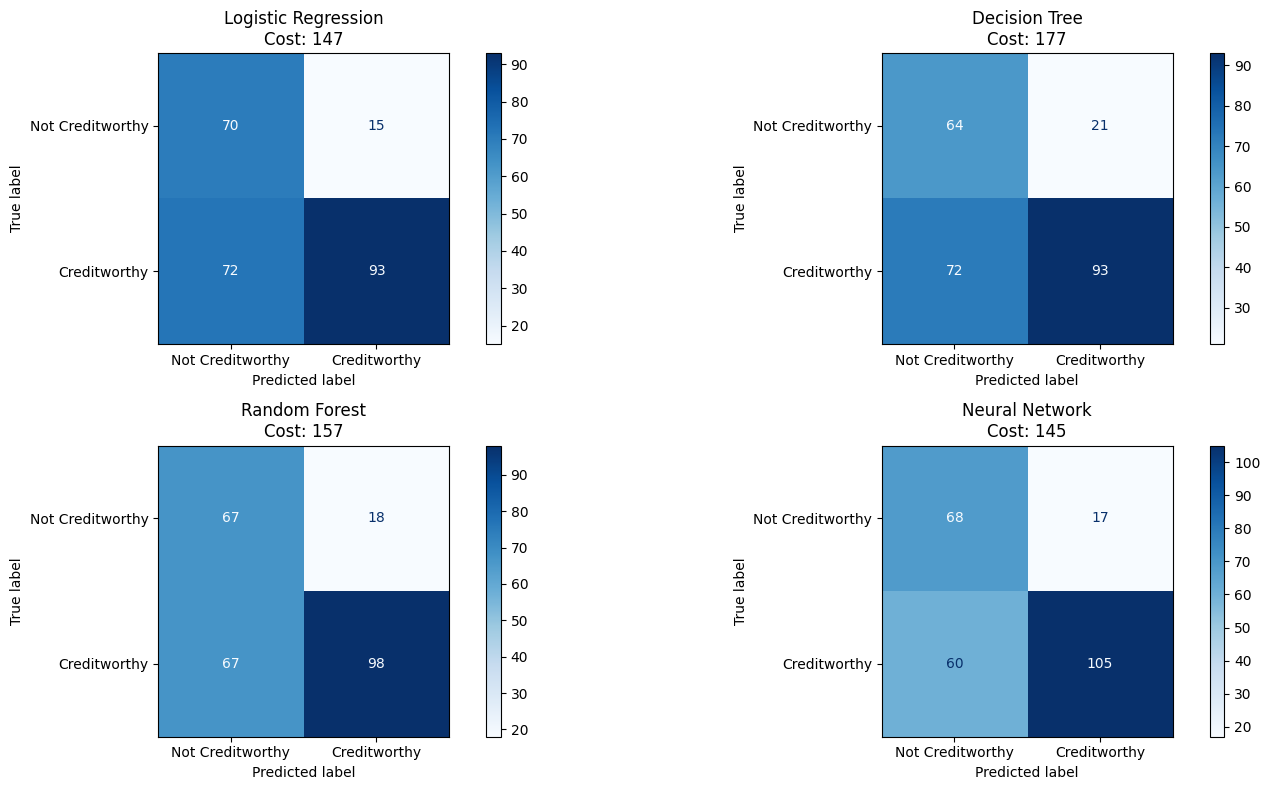

In [50]:
# Run evaluation
evaluation_results = evaluate_all_models(models, X_train, X_test, y_train, y_test)

### Model Performance Analysis
Based on the evaluation results and confusion matrices, we can see following characteristics in each model's performance:

#### Logistic Regression (Best Overall Balance)
- Second lowest cost among all models: **156**
- When it predicts creditworthy, it's correct **84.6%** of the time
- Captures **60%** of actual creditworthy cases

#### Decision Tree (Most Conservative)
- Highest cost among all models: **177**
- Lower reliability than Logistic Regression (**81.6%**)
- Very conservative, capturing only **56.4%** creditworthy applicants

#### Random Forest (Ensemble Improvement)
- Cost is very close to Logistic Regression: **161**
- Precision is similar to Logistic Regression (**83.9%**)
- Recall is better than Decision Tree but did not surpass Logistic Regression (**60%**)

#### Neural Network (Highest Precision, Low Recall)
- Lowest cost overall: **148**
- When it predicts creditworthy, it's correct almost **90%** of the time, however it is extremely conservative, missing **78%** of creditworthy instances.
- To minimize the false positives, it shows the lowest recall of **22%**.

In summary, all models show high precision as they are tuned to avoid costly false positive mistakes. Because of that, recall is very low and varies significantly from one model to another.

## Model Comparison

We use both **Precision-Recall Curves** and **ROC-AUC Curves** for model comparison. 

In [46]:
def plot_model_comparison_curves(models_dict, X_test, y_test):
    """
    Plot Precision-Recall and ROC-AUC curves for all models.
    """
    
    # Set up the plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Colors for different models
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    for idx, (model_name, model) in enumerate(models_dict.items()):
        color = colors[idx % len(colors)]
        
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Roc Curve
        roc_display = RocCurveDisplay.from_predictions(
            y_test, y_pred_proba,
            name=f'{model_name}',
            color=color,
            ax=ax2,
        )
        
        # Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        avg_precision = average_precision_score(y_test, y_pred_proba)
        
        ax1.plot(recall, precision, color=color, lw=2, 
                label=f'{model_name} (AP={avg_precision:.3f})')
        

    # Precision-Recall plot
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('Precision-Recall Curves')
    ax1.legend(loc='lower left')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.02])
    
    # Add baseline for PR curve
    baseline_precision = sum(y_test) / len(y_test)
    ax1.axhline(y=baseline_precision, color='gray', linestyle='--', 
                label=f'Random Classifier (AP={baseline_precision:.3f})')
    ax1.legend(loc='lower left')
    
    # ROC plot customization
    ax2.set_title('ROC Curves')
    ax2.grid(True, alpha=0.3)
    ax2.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
    ax2.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()

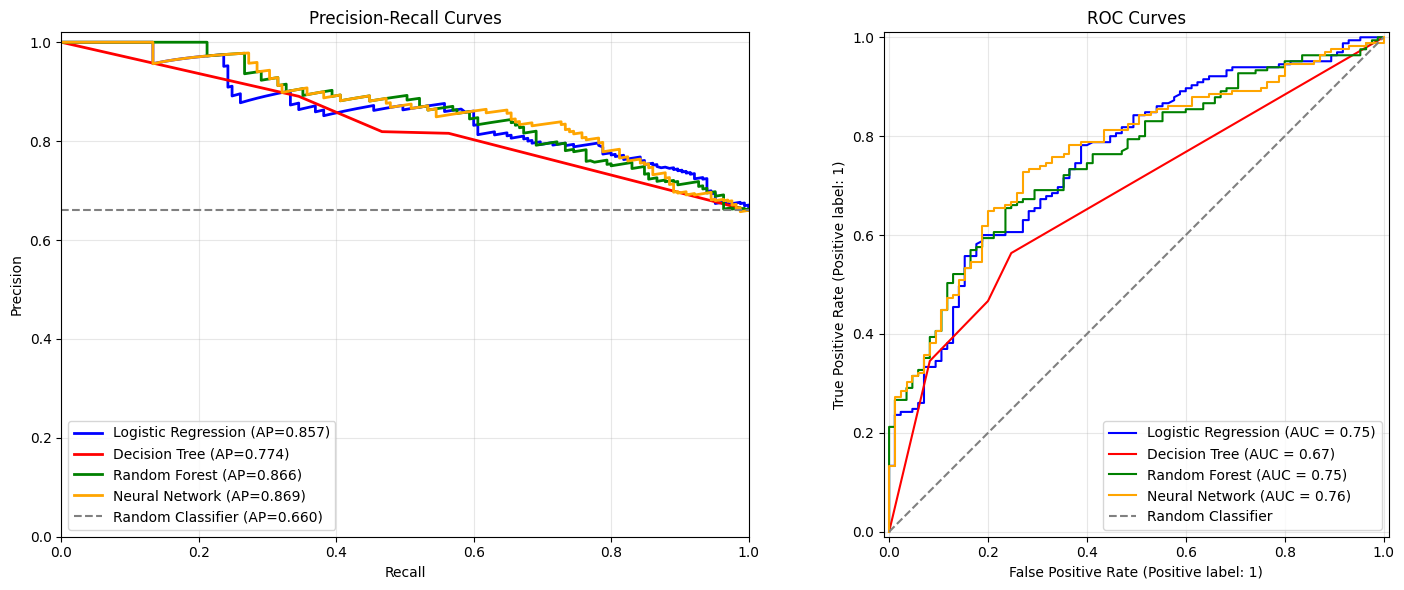

In [51]:
plot_model_comparison_curves(models, X_test, y_test)

#### Key Observation
- Random Forest achieves the highest Average Precision (**86.6%**), as well as highest AUC (**75%**)
- Neural Network shows competetive performance (**85%** AP, **75%** AUC) despite having limited data
- Logistic Regression follows closely: AP = **84.8%**, AUC = **73%**
- Decision Tree has the lowest AP (**77.4%**) and AUC (**67%**), reflecting its poor performance in our evaluation

All models significantly outperform random classification.

## Conclusion

This credit risk assessment compared four machine learning approaches. Among them, Random Forest and Logistic Regression stood out as the most reliable models. Random Forest achieved the best predictive performance (AP = 86.6%, AUC = 75%) but required higher computational resources. Logistic Regression, while slightly behind in performance (AP = 84.8%, AUC = 73%), offered a simpler and more computationally efficient alternative. Neural Network minimized cost but had low recall, and Decision Tree underperformed overall though it might be helpful in terms of interpretability. 

For a balance of cost, precision and efficiency, **Logistic Regression** represents the optimal choice.
